In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
movies = pd.read_csv('data/IMDB_movie_details.csv').reset_index(drop=True)
reviews = pd.read_json('data/IMDB_reviews.json', lines = True)

movies.movie_id = movies.movie_id.astype('str')
reviews.movie_id = reviews.movie_id.astype('str')


## Info about movies

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1339 non-null   object 
 7   title          1570 non-null   object 
dtypes: float64(1), object(7)
memory usage: 98.4+ KB


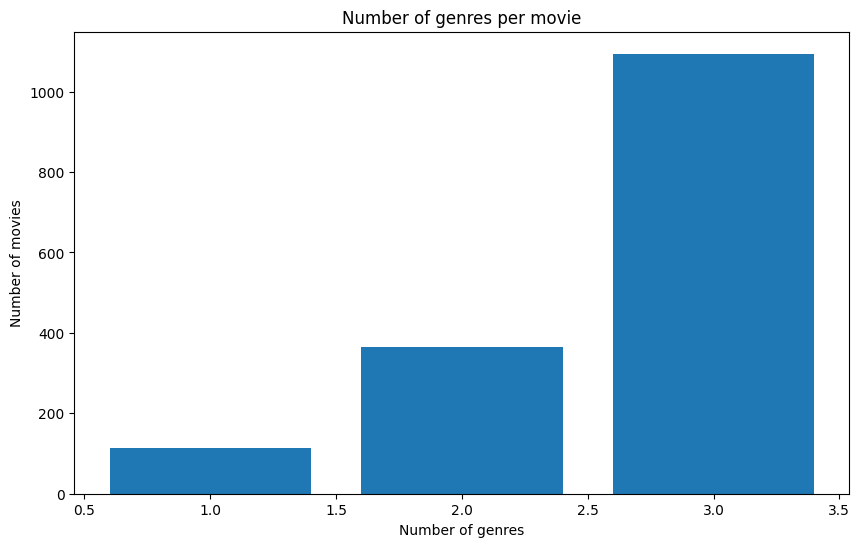

In [4]:
# get the # genres per movie
movies['genre'] = movies['genre'].str.split(',')
gen_len =  movies['genre'].apply(lambda x: len(x))
gen_lens = dict(gen_len.value_counts())
#plot the content of this dictionary
plt.figure(figsize=(10,6))
plt.bar(gen_lens.keys(), gen_lens.values())
plt.title('Number of genres per movie')
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.show()



In [5]:
movies[movies.title.isna()]

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,title
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[['Comedy', 'Drama']]",5.3,1992-02-21,NaN,NaN
1571,tt0114142/,"The marriage of David Burgess, a senior execut...",1h 32min,"[['Drama', 'Thriller']]",4.0,1999-01-29,NaN,NaN


In [6]:
movies.loc[movies.title.isna() , 'movie_id']

1570    tt0104014/
1571    tt0114142/
Name: movie_id, dtype: object

In [7]:
#remove / from these two movie_ids
movies.loc[movies.title.isna() , 'movie_id'] = movies.loc[movies.title.isna() , 'movie_id'].str.replace('/','')

In [8]:
movies[movies.title.isna()]

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,title
1570,tt0104014,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[['Comedy', 'Drama']]",5.3,1992-02-21,NaN,NaN
1571,tt0114142,"The marriage of David Burgess, a senior execut...",1h 32min,"[['Drama', 'Thriller']]",4.0,1999-01-29,NaN,NaN


In [9]:
from bs4 import BeautifulSoup
import requests
import random

user_agents_list = [
    'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:99.0) Gecko/20100101 Firefox/99.0',
    'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36 Edg/99.0.1150.46',
    'Mozilla/5.0 (Linux; Android 10; SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.58 Mobile Safari/537.36']

# add a bar to show the progress of the scraping
count = 0

#scrape the movie title
def get_title(movie_id):
    response = requests.get(f"https://www.imdb.com/title/{movie_id}/", headers = {'User-Agent': random.choice(user_agents_list)})
    soup =  BeautifulSoup(response.content, 'html.parser')
    global count 
    count += 1
    if count % 100 == 0:
        print(count)
    try:
        title = soup.find('h1').text
        return title
    except:
        return None

movies.loc[movies.title.isna(), 'title'] = movies.loc[movies.title.isna(), 'movie_id'].apply(get_title)


In [10]:
len(movies[movies.title.isna()]) == 0

True

In [12]:
# movies.to_csv('movies.csv', index=False)

c:\Users\lepol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lepol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


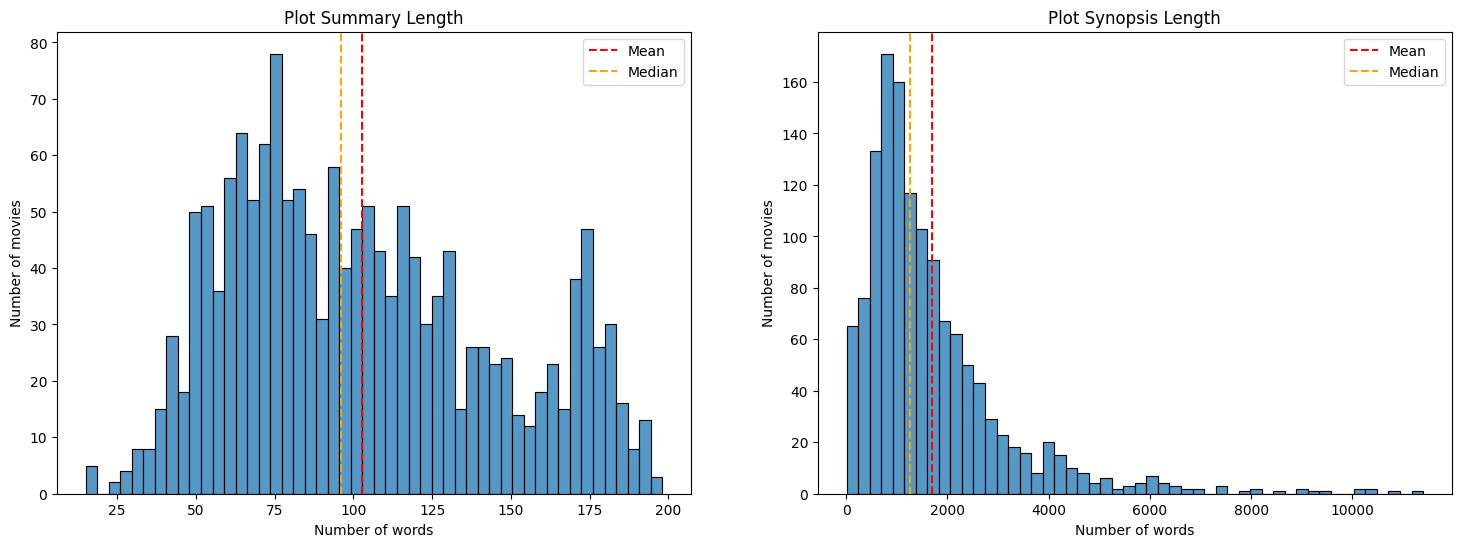

In [13]:
# plot average length of plot summary and synopsis
movies['plot_summary_len'] = movies.plot_summary.apply(lambda x: len(x.split()))
mov_temp = movies[movies.plot_synopsis.apply(lambda x: type(x) == str)].copy()
mov_temp['plot_synopsis_len'] = mov_temp.plot_synopsis.apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(movies['plot_summary_len'], bins=50, ax=ax[0])
#put vertical line on the mean and median and show their values in the legend
ax[0].axvline(movies['plot_summary_len'].mean(), color='red', linestyle='--', label='Mean')
ax[0].axvline(movies['plot_summary_len'].median(), color='orange', linestyle='--')
ax[0].set_title('Plot Summary Length')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of movies')
ax[0].legend({'Mean':movies['plot_summary_len'].mean(),'Median':movies['plot_summary_len'].median()})

sns.histplot(mov_temp['plot_synopsis_len'], bins=50, ax=ax[1])
ax[1].axvline(mov_temp['plot_synopsis_len'].mean(), color='red', linestyle='--')
ax[1].axvline(mov_temp['plot_synopsis_len'].median(), color='orange', linestyle='--')
ax[1].set_title('Plot Synopsis Length')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of movies')
ax[1].legend({'Mean':mov_temp['plot_synopsis_len'].mean(),'Median':mov_temp['plot_synopsis_len'].median()})
plt.show()

In [14]:
print(len(movies[movies.plot_synopsis.isna()]))

233


In [15]:
diff = set(reviews.movie_id) - set(movies.movie_id)
reviews[reviews.movie_id.isin(diff)].head()  

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary


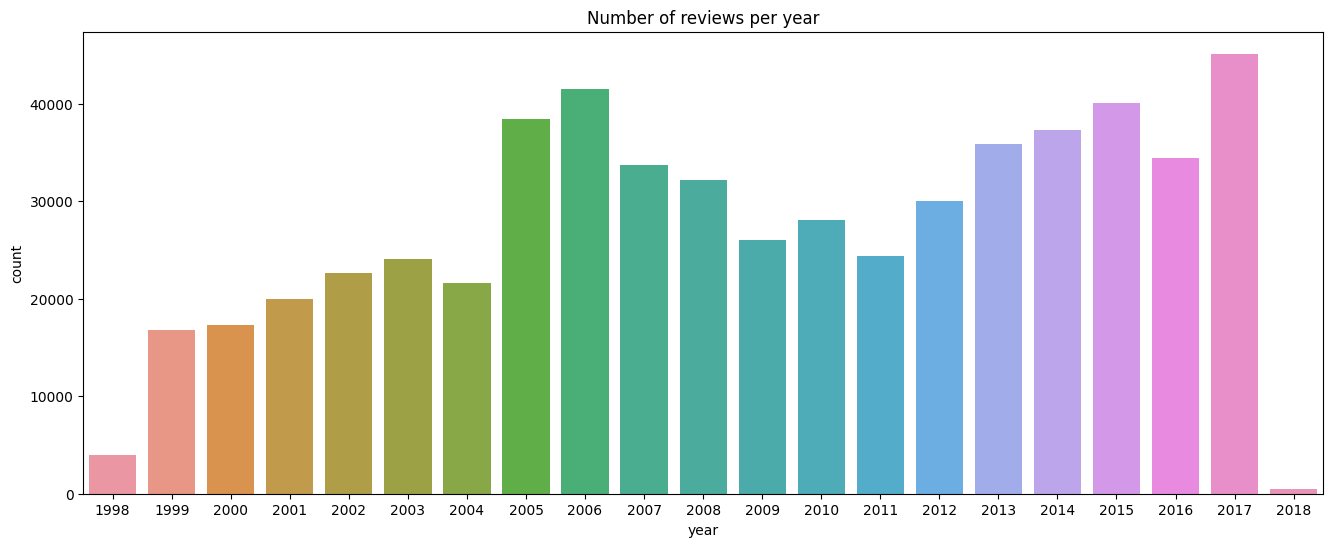

In [16]:
reviews.review_date = pd.to_datetime(reviews.review_date)
reviews['year'] = reviews.review_date.dt.year
plt.figure(figsize=(16,6))
sns.countplot(x='year', data=reviews)    
plt.title('Number of reviews per year')
plt.show()

In [17]:
len(reviews[reviews.year == 2018])

528

## Spoiler focused

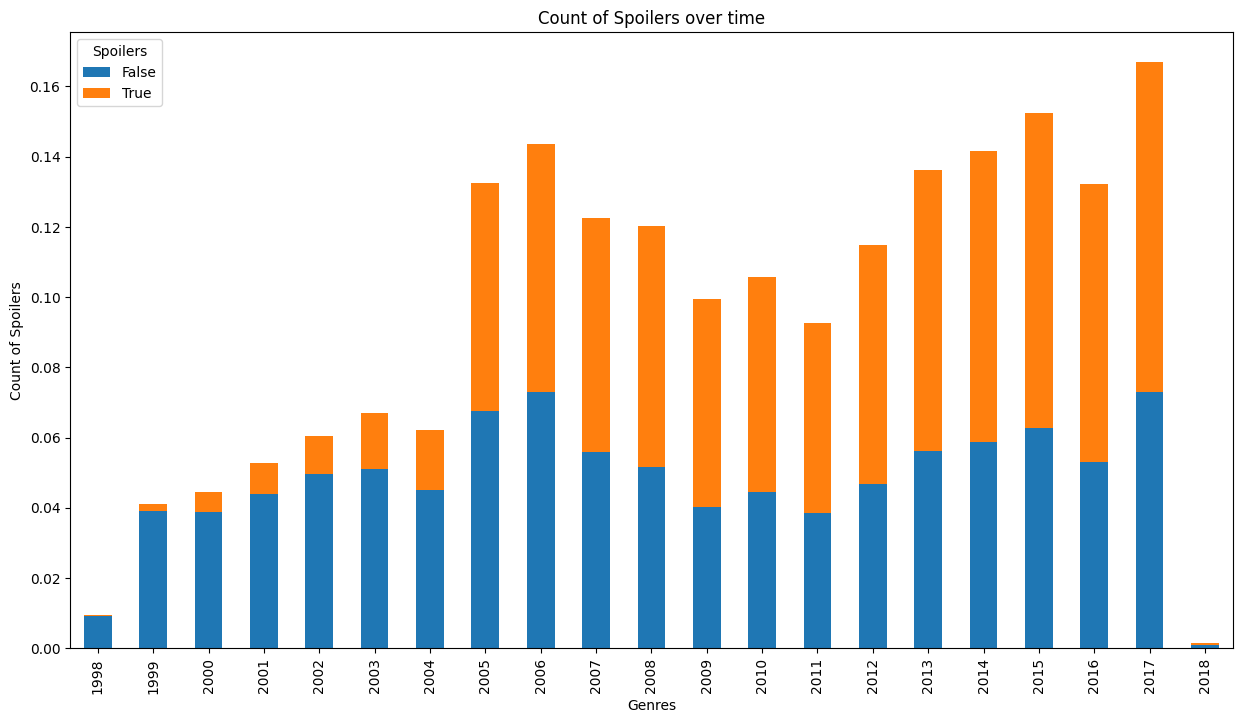

In [18]:
crosstab = pd.crosstab(reviews.year, reviews['is_spoiler'].values, normalize= 'columns')
# plot a crosstab that shows the count of spoilers over time by the spoiler fraction of each year

crosstab.plot(kind='bar', stacked=True,  figsize=(15,8) )
plt.title('Count of Spoilers over time')
plt.xlabel('Genres')
plt.ylabel('Count of Spoilers')
plt.legend(title='Spoilers')
plt.show()

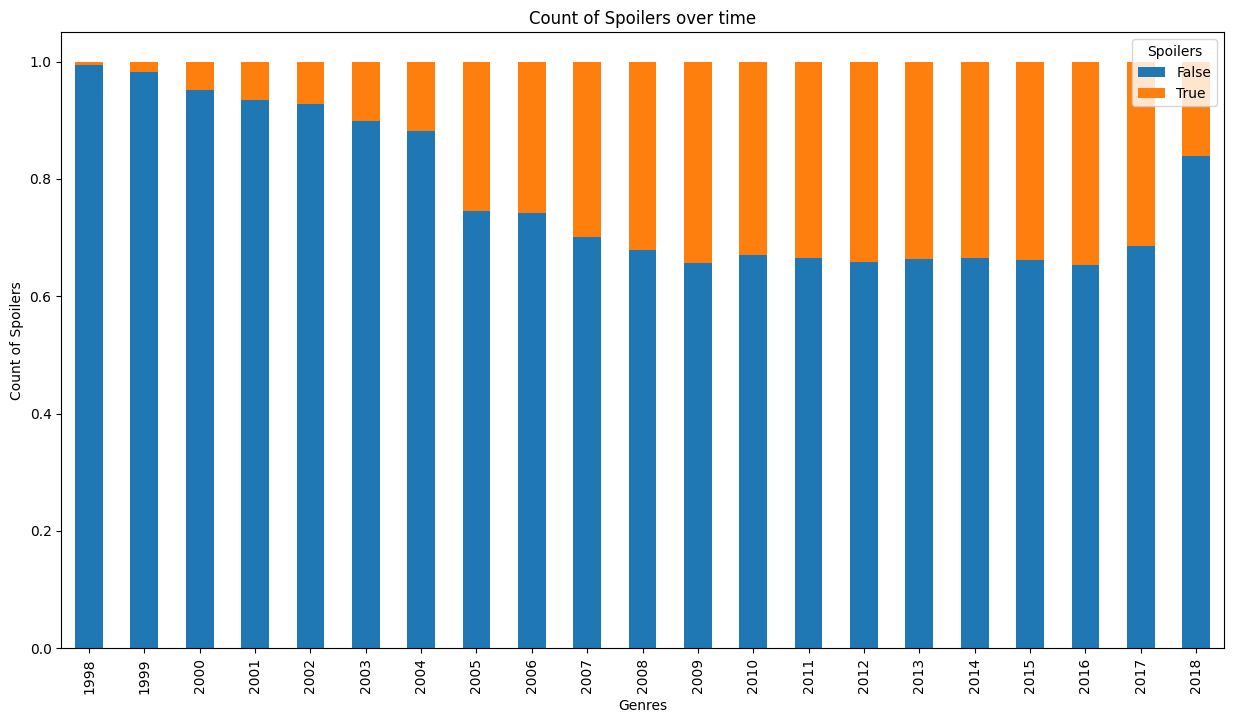

In [19]:
crosstab = pd.crosstab(reviews.year, reviews['is_spoiler'].values, normalize= 'index')
# plot a crosstab that shows the count of spoilers over time by the spoiler fraction of each year

crosstab.plot(kind='bar', stacked=True,  figsize=(15,8) )
plt.title('Count of Spoilers over time')
plt.xlabel('Genres')
plt.ylabel('Count of Spoilers')
plt.legend(title='Spoilers')
plt.show()

clearly, 2018 has so few reviews that can be discarded

In [20]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   review_date     573913 non-null  datetime64[ns]
 1   movie_id        573913 non-null  object        
 2   user_id         573913 non-null  object        
 3   is_spoiler      573913 non-null  bool          
 4   review_text     573913 non-null  object        
 5   rating          573913 non-null  int64         
 6   review_summary  573913 non-null  object        
 7   year            573913 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 29.0+ MB


## Merge movies and reviews

In [21]:
df = pd.merge(movies, reviews, on='movie_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   movie_id          573913 non-null  object        
 1   plot_summary      573913 non-null  object        
 2   duration          573913 non-null  object        
 3   genre             573913 non-null  object        
 4   rating_x          573913 non-null  float64       
 5   release_date      573913 non-null  object        
 6   plot_synopsis     538828 non-null  object        
 7   title             573913 non-null  object        
 8   plot_summary_len  573913 non-null  int64         
 9   review_date       573913 non-null  datetime64[ns]
 10  user_id           573913 non-null  object        
 11  is_spoiler        573913 non-null  bool          
 12  review_text       573913 non-null  object        
 13  rating_y          573913 non-null  int64         
 14  revi

In [22]:
%%capture
!pip install llamaapi -q

In [ ]:
df.head()

In [ ]:
for row in df.review_text.head(2):
    print(row)

In [ ]:
import json
from llamaapi import LlamaAPI


# Initialize the SDK
llama = LlamaAPI("LL-ArvEChPTRTiSM5ASZLmSyMFgzt4sJoUYOCud9jvYjG4m40WqJfvRrO8DVMAehr7f")


# JSON payload as provided
api_request_json = {

    "messages": [
        {"role": "assistant", "content": f"Take this plot summary to understand the concepts. Plot summary: {df.plot_summary[0]}."},
        {"role": "assistant", "content": f"Take this plot synopsis to understand how to remove spoilers. Plot synopsis: {df.plot_synopsis[0]}"},
         
        {"role": "user", "content": f"Rephrase this review to remove any spoiler present in the summary by leveraging the synopsis: {df.review_text[0]}"},

    ]
}


response = llama.run(api_request_json)
print(response.content)


In [ ]:
print(response.text)

In [ ]:
import re 

output = response.json()['choices'][0]['message']['content']
output
# take only what comes after \n\n
output = output.split('\n\n')[1]
output

In [ ]:
df.review_text[0]